# Plotting Time Series from Multiple Ensemble Members
## (using Regions Defined by Shape Files!)
### Authors

Samantha Stevenson sstevenson@ucsb.edu

### Table of Contents

[Goals](#purpose)

[Import Packages](#path)

[Load and Query the CMIP6 AWS Catalog](#load)

[Read in Data as an Xarray Object](#xarray)

[Define a Region Using Shapefiles](#shapefiles)

[Plot Time Series](#time_series)

<a id='purpose'></a> 
## **Goals**

In this tutorial, we will be reading in the database of Coupled Model Intercomparison Project phase 6 (CMIP6) output hosted by Amazon Web Services and exploring its contents. 

The steps in this tutorial build on the skills we learned in previous tutorials:
- [Read in Data and Plot a Time Series](https://github.com/climate-datalab/Time-Series-Plots/blob/main/1.%20Read%20in%20Climate%20Data%20%2B%20Plot%20a%20Regionally%20Averaged%20Time%20Series.ipynb)
  (regional averaging, time series plotting)
- [Opening and Querying the CMIP6 AWS Database](https://github.com/climate-datalab/CMIP6_AWS/blob/main/1.%20Opening%20and%20Querying%20the%20CMIP6%20Catalog.ipynb)  (data access via Amazon Web Services)

Basically: we'll be doing a lot of the same things we did in those tutorials, but this time extending the plots to include information from multiple _ensemble members_ and multiple climate models! Please refer back to those materials if you would like additional detail.

<a id='path'></a> 
## **Import Packages**

As always, we begin by importing the necessary packages for our analysis. This tutorial assumes you're starting with an environment in which `intake`, `intake-esm`, and `s3fs` are already installed - for details on those packages, see the [CMIP6 AWS repo](https://github.com/climate-datalab/CMIP6_AWS)!

We'll also need a new package for this tutorial: `geopandas`. [Geopandas](https://geopandas.org/en/stable/index.html) is designed to facilitate working with geospatial data in Python; it layers the functionality of Pandas with the shape-handing abilities of Shapely to allow users to perform operations on geometrics objects. 

Last but not least: we'll also import the coordinate reference system handling functionality from Cartopy (`cartopy.crs`; for more details see the [Cartopy CRS docs page](https://scitools.org.uk/cartopy/docs/latest/getting_started/crs.html)). This will allow us to reproject geospatial data onto a given CRS using Geopandas later on! 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
from shapely.geometry import Point

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


<a id='load'></a> 
## **Load and Query the CMIP6 AWS Catalog**

As we did in previous tutorials, we'll load the CMIP6 database hosted by Amazon Web Services. More detail on that database is available on the [Amazon Registry of Open Data](https://registry.opendata.aws/cmip6/).


We first begin with opening the data catalog itself (_note - this step can be fairly slow on some machines_):

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

Now, let's do some more sophisticated analysis! Rather than pulling down information from a single simulation, we'll aim to gather all of the _ensemble members_ for two different climate models. 

#### **What is an ensemble member??**

This is a term we've thrown around in a couple of tutorials now - let's dig in and think about it a little more!

The broad definition of an ensemble member is: **a single simulation run with a given climate model, for a given configuration**, where "configuration" here means that you've set the model up in a particular way (for instance: to run a simulation of the historical period, or for a specific future scenario). The _difference between ensemble members is ONLY that they have slightly different INITIAL CONDITIONS_ - everything else is the same!

Here is a schematic example showing how you can think of ensemble members: since they begin in slightly different places, their _time evolution_ will be a little different (think differences between weather forecasts). But the background effects of _forced_ changes to the climate system will be the same in all members (since they set up all the members exactly the same way); so by averaging together all the different ensemble members, you can get a really good estimate of the total changes due to, for instance, climate change!

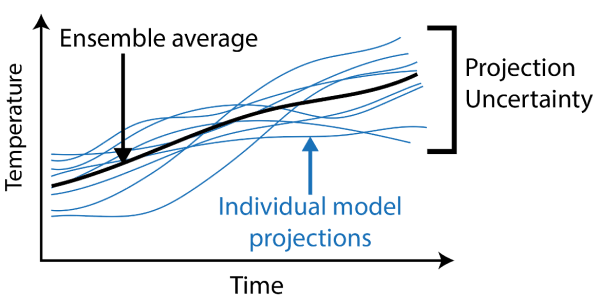



Let's display data from a couple of members of a single ensemble, to get a better idea of how that works. We'll start with picking a model, the Community Earth System Model version 2 (CESM2) - let's begin with the historical information, to make things simpler.

Set the following fields to extract this information from the CMIP6 catalog:

- **activity_id**: here we want "CMIP" since that's where the historical simulations live

- **source_id**: this is the name of the model, so "CESM2"

- **experiment_id**: the type of simulation we want, here "historical"

- **table_id**: the category of output variable we're looking for. For surface air temperature, this will be in the atmosphere, and we'll pull out monthly data to make the files smaller: that means the "Amon" table is what we want!

- **variable_id**: the actual name of the variable, here "tas"

In [3]:
# Specify search terms to query catalog 
# activity_id: which project do you want? CMIP = historical data
activity_ids = ['CMIP'] 

# source_id: which model do you want? Let's say CESM2
source_id = ['CESM2']

# experiment_id: what experimental configuration do you want? Here we want historical and the four main SSPs
experiment_ids = ['historical']

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = 'Amon' 

# variable_id: which climate variable do you want? Here we want surface air temperature
variable_id = 'tas' 

As we did in tutorial 1, we now apply the `.search` functionality to retrieve the information we want, then convert it to a data frame that we can work with:

In [4]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
1,CMIP,NCAR,CESM2,historical,r6i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
2,CMIP,NCAR,CESM2,historical,r3i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
3,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
4,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
5,CMIP,NCAR,CESM2,historical,r5i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
6,CMIP,NCAR,CESM2,historical,r9i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
7,CMIP,NCAR,CESM2,historical,r8i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
8,CMIP,NCAR,CESM2,historical,r7i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
9,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190313


Looking at the data frame displayed above, you might notice a couple of things. First: a lot of the entries seem nearly identical! That's good - after all, we're trying to get data from a SINGLE experiment with a SINGLE model.

The entries that show up as DIFFERENT between the data frame rows above are:

- **member_id**: this is where the names of the different ensemble members are stored. They will be things like "r10i1p1f1", "r16i1p1f1", etc. For more detail on how the member names work, you can refer back to the [Climate DataLab filename decoder](https://climate-datalab.org/filename-decoder/).

- **zstore**: this is the location of a given ensemble member on the remote server (in this case, Amazon Web Services cloud hosting). This is what you'll need to refer to in order to load the data into local memory as an xarray object!

<a id='xarray'></a> 
## **Read in Data as an Xarray Object**

Now we can read in the zarr stores containing the actual information. I'm going to do this in a few steps, which might seem a bit complicated at first but will make it easier to work with the data once it's read in!


**1) Define an empty list**

First, we define an empty object that can be used to store the set of data from all of our ensemble members.

**2) Loop over all entries in the data frame**

Now we loop over all the entries in the data frame, so that we can read each of these in as individual xarray objects. Here I have retrieved the total number of entries first, using the `.shape` command applied to the data frame: the dimension of the data frame is \[number of data entries\] x \[number of data columns\], so we want the first value output by `.shape`. 

To get the loop to step through the data frame, I use the `range` command: this creates a range of integers starting with 0 and ending with one less than the value you give it. So `range(10)` will give you the integers from 0 to 9, and so on.

**3) Store data from each entry as xarray, add to list**

Inside the loop, we next use `xr.open_zarr` to read in each individual entry as an xarray object. Note that we again have to specify that anonymous access is allowed using the syntax `storage_options={'anon': True}`. Each xarray object is then appended to the empty list we initialized before the loop began - now we have a list of xarray Datasets!

**4) Concatenate the list into a single xarray object**

After the loop finishes, we can convert the list of xarray Datasets into a new Dataset with an additional dimension, for which we can specify a new name. This is done via the xarray `.concat` method; I like to call the dimension "member" since it refers to ensemble members.

As a nice bonus, we can also store the names of the actual ensemble members as value of the new "member" coordinate - that way we can keep track of that information in case we need it later. This is done using the `.assign_coords` function within xarray!

In [5]:
# Define an empty list
ens_data = []

# Retrieve number of entries in the data frame
num = res.df.shape[0]

# Loop over all entries in the data frame
for mem in range(num):
    print(res.df.member_id[mem])
    # Store data from each entry as xarray, add to list
    temp_data = xr.open_zarr(res.df['zstore'][mem], storage_options={'anon': True})
    ens_data.append(temp_data)

# Concatenate the list into a single xarray object
ens_data = xr.concat(ens_data, dim="member")

# Store the actual member information as values of the new dimension
ens_data = ens_data.assign_coords(member=("member", res.df.member_id))

r4i1p1f1
r6i1p1f1
r3i1p1f1
r1i1p1f1
r2i1p1f1
r5i1p1f1
r9i1p1f1
r8i1p1f1
r7i1p1f1
r10i1p1f1
r11i1p1f1


In [6]:
# Look at the new dataset we've created
print(ens_data)

<xarray.Dataset>
Dimensions:    (lat: 192, member: 11, nbnd: 2, lon: 288, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (member, lat, nbnd) float64 dask.array<chunksize=(1, 192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 -0.625 0.625 0.625 ... 358.1 358.1 359.4
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
  * member     (member) object 'r4i1p1f1' 'r6i1p1f1' ... 'r10i1p1f1' 'r11i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_t

<a id='shapefiles'></a> 
## **Define a Region Using Shapefiles**

Now that the data have been read in, we can use it to plot a time series. In previous tutorials, we had been specifying lat/lon ranges using a rectangular box: but we can do better now! A common desire in analyzing geospatial data is to select regions with irregular boundaries - this is often done using shapefiles which specify the lat/lon coordinates of the boundary around a given region. 

There are many sources of shapefiles around the Internet: here we'll work with the [California Geographic Boundaries](https://catalog.data.gov/dataset/ca-geographic-boundaries) datasets. These contain information for state, county, and local place boundaries - to make sure we have a large enough region, let's use the state boundary. 

The shape file for the California state boundary was downloaded from the link above and is stored in this repo! 

In [7]:
# Read in shapefile for CA counties
gdf = gpd.read_file('ca_state/CA_State.shp')

proj = ccrs.PlateCarree(central_longitude=180)
# Reproject to match Cartopy plotting projection
gdf = gdf.to_crs(epsg=4326)

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = proj.proj4_init
gdf_cp = gdf.to_crs(crs_proj4)


In [10]:
import numpy as np
# Create a GeoDataFrame from the xarray dataset's coordinates
points = [Point(lon, lat) for lon, lat in zip(ens_data.lon.values.flatten(), ens_data.lat.values.flatten())]
points_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")


In [13]:

# Spatial join to find points within the shapefile
joined = gpd.sjoin(points_gdf, gdf, how="inner", predicate="intersects")

# Create a mask based on the spatial join
mask = np.isin(np.arange(points_gdf.shape[0]), joined.index)
mask_2d = mask.reshape(ens_data.lat.shape)

masked_data = temp_data.where(mask_2d)


ValueError: operands could not be broadcast together with shapes (192,) (1980, 192, 288) ()

In [ ]:
# Concatenate historical and future projection data
canesm5_data = xr.concat([hist_data, ssp370_data], dim="time")

Recall that the CanESM5 uses a non-standard 365-day year (no leap years), and to get the plotting to work correctly we have to convert the time format to `datetime64`:

In [ ]:
# Convert time to datetime64 format
time = canesm5_data.time.astype('datetime64[ns]')

Now we follow the rest of the steps from the previous tutorial to define lat/lon bounds, mask the data, and compute a regional average:

In [ ]:
# Define min/max bounds for region of interest (NYC)
lat_min, lat_max = 40, 41.5
lon_min, lon_max = 285.5, 287

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
tas_NYC_lat = (canesm5_data.lat >= lat_min) & (canesm5_data.lat <= lat_max)
tas_NYC_lon = (canesm5_data.lon >= lon_min) & (canesm5_data.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_NYC = canesm5_data.where(tas_NYC_lat & tas_NYC_lon, drop=True)

# Average over lat, lon dimensions to get a time series
tas_NYC = tas_NYC.mean(dim=["lat", "lon"])

and finally, generate our plot!

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(time, tas_NYC.tas, label='Near-Surface Air Temperature', color='b')
ax.set_title("Time Series of NYC Near-Surface Air Temperature (1850 to 2100) ", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (K)", fontsize=20)
ax.legend(fontsize=20)
ax.grid()
plt.show()

Yay! Now you can compare this plot to the one you generated in the original tutorial, and see what they look like (hint: the historical portions should be the same!)